In [16]:
import pandas as pd
import numpy as np

Here we are getting the dataframes to extract information about the carbon intensity

In [17]:
es_2023 = pd.read_csv('datasets/ES_2023_hourly.csv')
es_2024 = pd.read_csv('datasets/ES_2024_hourly.csv')

In [18]:
es_combined = pd.concat([es_2023, es_2024], ignore_index=True)
es_combined

,Datetime (UTC),Country,Zone Name,Zone Id,Carbon Intensity gCO₂eq/kWh (direct),Carbon Intensity gCO₂eq/kWh (LCA),Low Carbon Percentage,Renewable Percentage,Data Source,Data Estimated,Data Estimation Method
0,2023-01-01 00:00:00,Spain,Spain,ES,79.49,110.37,84.15,50.75,entsoe.eu,False,NaN
1,2023-01-01 01:00:00,Spain,Spain,ES,82.59,113.77,83.73,49.24,entsoe.eu,False,NaN
2,2023-01-01 02:00:00,Spain,Spain,ES,83.20,114.28,83.75,47.23,entsoe.eu,False,NaN
3,2023-01-01 03:00:00,Spain,Spain,ES,83.55,114.91,83.75,45.71,entsoe.eu,False,NaN
4,2023-01-01 04:00:00,Spain,Spain,ES,84.06,115.32,83.73,44.10,entsoe.eu,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,Spain,Spain,ES,174.64,226.28,61.88,32.70,entsoe.eu,False,NaN
17540,2024-12-31 20:00:00,Spain,Spain,ES,178.07,231.38,60.84,30.12,entsoe.eu,False,NaN
17541,2024-12-31 21:00:00,Spain,Spain,ES,182.38,239.18,59.04,26.26,entsoe.eu,False,NaN
17542,2024-12-31 22:00:00,Spain,Spain,ES,174.63,229.87,61.00,26.57,entsoe.eu,False,NaN


In [19]:
carbon_df = es_combined[['Datetime (UTC)', 'Carbon Intensity gCO₂eq/kWh (direct)']]
carbon_df['Datetime (UTC)'] = pd.to_datetime(carbon_df['Datetime (UTC)'])
carbon_df

C:\Users\juanf\AppData\Local\Temp\ipykernel_23252\619389603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_df['Datetime (UTC)'] = pd.to_datetime(carbon_df['Datetime (UTC)'])


,Datetime (UTC),Carbon Intensity gCO₂eq/kWh (direct)
0,2023-01-01 00:00:00,79.49
1,2023-01-01 01:00:00,82.59
2,2023-01-01 02:00:00,83.20
3,2023-01-01 03:00:00,83.55
4,2023-01-01 04:00:00,84.06
...,...,...
17539,2024-12-31 19:00:00,174.64
17540,2024-12-31 20:00:00,178.07
17541,2024-12-31 21:00:00,182.38
17542,2024-12-31 22:00:00,174.63


In [20]:
#Add variables for month, day, hour
carbon_df['month'] = carbon_df['Datetime (UTC)'].dt.month
carbon_df['day'] = carbon_df['Datetime (UTC)'].dt.day
carbon_df['hour'] = carbon_df['Datetime (UTC)'].dt.hour

#Add variable for day of week
carbon_df['day_of_week'] = carbon_df['Datetime (UTC)'].dt.dayofweek

#Add variable for weekend
carbon_df['weekend'] = carbon_df['day_of_week'].apply(lambda x: 1 if x > 4 else 0)


C:\Users\juanf\AppData\Local\Temp\ipykernel_23252\3732579441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_df['month'] = carbon_df['Datetime (UTC)'].dt.month
C:\Users\juanf\AppData\Local\Temp\ipykernel_23252\3732579441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_df['day'] = carbon_df['Datetime (UTC)'].dt.day
C:\Users\juanf\AppData\Local\Temp\ipykernel_23252\3732579441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [21]:
# Now we make a function to calculate the average carbon intensity for each hour of the day taking into account the same 
# forecasting month of the previous year.
def get_past_month_intensity(month_to_forecast: int, current_year: int):
    carbon_df.loc[:, 'Datetime (UTC)'] = pd.to_datetime(carbon_df['Datetime (UTC)'])
    carbon_df.loc[:, 'month'] = carbon_df['Datetime (UTC)'].dt.month
    carbon_df.loc[:, 'year'] = carbon_df['Datetime (UTC)'].dt.year
    carbon_df.loc[:, 'hour'] = carbon_df['Datetime (UTC)'].dt.hour
    
    mask = (carbon_df['month'] == month_to_forecast) & (carbon_df['year'] == current_year - 1)

    return carbon_df.loc[mask].groupby('hour')['Carbon Intensity gCO₂eq/kWh (direct)'].mean()

import matplotlib.pyplot as plt

def get_discharge_hours(intensity_df, month_to_forecast:int, current_year):
    intensity_df = get_past_month_intensity(month_to_forecast, current_year).reset_index()
    intensity_df = intensity_df[intensity_df['hour'] >= 15]
    intensity_df.sort_values('Carbon Intensity gCO₂eq/kWh (direct)', ascending=False, inplace=True)
    
    # Plot the intensity per hour as a barplot
    plt.figure(figsize=(10, 6))
    plt.bar(intensity_df['hour'], intensity_df['Carbon Intensity gCO₂eq/kWh (direct)'])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Carbon Intensity gCO₂eq/kWh (direct)')
    plt.title('Carbon Intensity per Hour')
    plt.grid(True)
    plt.show()
    
    #Return the top hour to start discharging with the highest carbon intensity as values
    return intensity_df['hour'].values[0]

C:\Users\juanf\AppData\Local\Temp\ipykernel_23252\3543730597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_df.loc[:, 'year'] = carbon_df['Datetime (UTC)'].dt.year


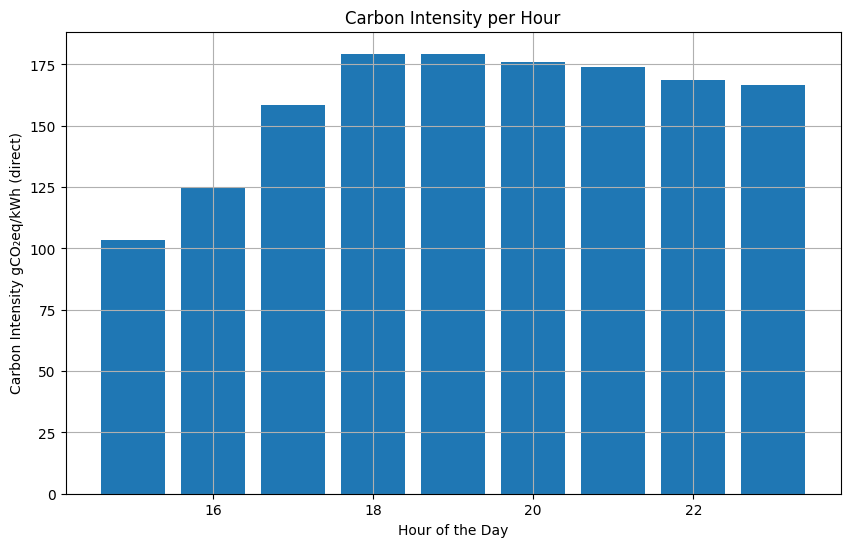

np.int32(18)

In [22]:
best_hour_to_discharge = get_discharge_hours(carbon_df, 9, 2024)
best_hour_to_discharge

In [23]:
solar_df = pd.read_csv('datasets/Best_LSTM_rounded.csv')
print(solar_df.head())

             Timestamp  BEST_LSTM
0  2024-09-01 00:00:00          0
1  2024-09-01 01:00:00          0
2  2024-09-01 02:00:00          0
3  2024-09-01 03:00:00          0
4  2024-09-01 04:00:00          0


In [24]:
#Now we are going to create the new df:
ra_df = pd.DataFrame()

#1. Add the hours of the month to forecast and the forecasted energy
date_range = pd.date_range(start='2024-09-01', end='2024-09-30 23:00:00', freq='h')
ra_df['ds'] = date_range

ra_df['hour'] = ra_df['ds'].dt.hour
ra_df['day'] = ra_df['ds'].dt.day

#solar_df = pd.read_csv('Best_Prediction.csv', sep=';', decimal=',')
solar_df = pd.read_csv('datasets/Best_LSTM_rounded.csv')
ra_df['Solar Energy Generated'] = solar_df['BEST_LSTM']

#2. Import the Solar Consumption
solar_consumption = pd.read_csv('datasets/consumo_fotovoltaica.csv')
ra_df['Solar Energy Consumed'] = solar_consumption['TOTAL_KWH_ENERGIA']

#3. Add the excess energy
ra_df['Excess Solar Energy'] = ra_df['Solar Energy Generated'] - ra_df['Solar Energy Consumed']
ra_df['Excess Solar Energy'] = ra_df['Excess Solar Energy'].apply(lambda x: max(x, 0))

#4. Import Total Energy Consumption
total_consumption = pd.read_csv('datasets/consumo_sept.csv')
ra_df['Total Energy Consumed'] = total_consumption['TOTAL_KWH_ENERGIA'].fillna(total_consumption['TOTAL_KWH_ENERGIA'].mean())

#5. Import the carbon intensity from september 2024
carbon_df = pd.read_csv('datasets/ES_2024_hourly.csv')
carbon_df['Datetime (UTC)'] = pd.to_datetime(carbon_df['Datetime (UTC)'])
carbon_df = carbon_df[carbon_df['Datetime (UTC)'].dt.month == 9]
carbon_list = carbon_df['Carbon Intensity gCO₂eq/kWh (direct)']
ra_df['Carbon Intensity gCO₂eq/kWh (direct)'] = carbon_list.values

#6. Add the CO2 emissions
ra_df['CO2 Emissions'] = ra_df['Carbon Intensity gCO₂eq/kWh (direct)'] * ra_df['Total Energy Consumed']


ra_df


,ds,hour,day,Solar Energy Generated,Solar Energy Consumed,Excess Solar Energy,Total Energy Consumed,Carbon Intensity gCO₂eq/kWh (direct),CO2 Emissions
0,2024-09-01 00:00:00,0,1,0,0.00,0.00,110.855888,170.04,18849.935258
1,2024-09-01 01:00:00,1,1,0,0.00,0.00,107.341202,175.13,18798.664668
2,2024-09-01 02:00:00,2,1,0,0.00,0.00,105.550308,175.53,18527.245603
3,2024-09-01 03:00:00,3,1,0,0.00,0.00,106.840103,174.22,18613.682771
4,2024-09-01 04:00:00,4,1,0,0.00,0.00,105.879791,175.05,18534.257460
...,...,...,...,...,...,...,...,...,...
715,2024-09-30 19:00:00,19,30,58,36.74,21.26,532.989990,164.57,87714.162693
716,2024-09-30 20:00:00,20,30,20,4.98,15.02,484.213684,156.86,75953.758485
717,2024-09-30 21:00:00,21,30,5,-0.04,5.04,243.039886,144.21,35048.782029
718,2024-09-30 22:00:00,22,30,0,0.00,0.00,111.581192,121.51,13558.230642


In [25]:
# Initialize new columns
ra_df['Battery Charge (kWh)'] = 0.0
ra_df['Battery Discharge (kWh)'] = 0.0
ra_df['Battery Level (kWh)'] = 0.0
ra_df['Grid Energy Used (kWh)'] = 0.0
ra_df['Adjusted CO2 Emissions (with Battery)'] = 0.0

battery_capacity = 100
discharge_hour = best_hour_to_discharge

for day in ra_df['day'].unique():
    day_df = ra_df[ra_df['day'] == day].copy()
    battery_level = 0.0

    for idx, row in day_df.iterrows():
        hour = row['hour']
        
        # Charge phase: before the discharge hour
        if hour < discharge_hour:
            charge = row['Excess Solar Energy']
            if charge > 0:
                available_capacity = battery_capacity - battery_level
                charge_to_store = min(charge, available_capacity)
                battery_level += charge_to_store
                ra_df.at[idx, 'Battery Charge (kWh)'] = charge_to_store

        # Discharge phase: from the discharge hour onward
        elif hour >= discharge_hour and battery_level > 0:
            energy_needed = row['Total Energy Consumed']
            discharge = min(energy_needed, battery_level)
            battery_level -= discharge
            ra_df.at[idx, 'Battery Discharge (kWh)'] = discharge

        # Track battery level at each hour
        ra_df.at[idx, 'Battery Level (kWh)'] = battery_level

        # Grid energy used = total consumption - battery discharge
        grid_energy = row['Total Energy Consumed'] - ra_df.at[idx, 'Battery Discharge (kWh)']
        ra_df.at[idx, 'Grid Energy Used (kWh)'] = max(0, grid_energy)

        # Adjusted CO2 emissions using grid energy only
        carbon_intensity = row['Carbon Intensity gCO₂eq/kWh (direct)']
        ra_df.at[idx, 'Adjusted CO2 Emissions (with Battery)'] = carbon_intensity * grid_energy

    

In [26]:
ra_df.head()

,ds,hour,day,Solar Energy Generated,Solar Energy Consumed,Excess Solar Energy,Total Energy Consumed,Carbon Intensity gCO₂eq/kWh (direct),CO2 Emissions,Battery Charge (kWh),Battery Discharge (kWh),Battery Level (kWh),Grid Energy Used (kWh),Adjusted CO2 Emissions (with Battery)
0,2024-09-01 00:00:00,0,1,0,0.0,0.0,110.855888,170.04,18849.935258,0.0,0.0,0.0,110.855888,18849.935258
1,2024-09-01 01:00:00,1,1,0,0.0,0.0,107.341202,175.13,18798.664668,0.0,0.0,0.0,107.341202,18798.664668
2,2024-09-01 02:00:00,2,1,0,0.0,0.0,105.550308,175.53,18527.245603,0.0,0.0,0.0,105.550308,18527.245603
3,2024-09-01 03:00:00,3,1,0,0.0,0.0,106.840103,174.22,18613.682771,0.0,0.0,0.0,106.840103,18613.682771
4,2024-09-01 04:00:00,4,1,0,0.0,0.0,105.879791,175.05,18534.257460,0.0,0.0,0.0,105.879791,18534.257460


In [27]:
total_solar_energy_generated = ra_df['Solar Energy Generated'].sum()
total_solar_energy_consumed = ra_df['Solar Energy Consumed'].sum()
total_excess_solar_energy = ra_df['Excess Solar Energy'].sum()
total_CO2_emissions = ra_df['CO2 Emissions'].sum()
total_battery_charge = ra_df['Battery Charge (kWh)'].sum()
total_battery_discharge = ra_df['Battery Discharge (kWh)'].sum()
total_optimized_CO2_emissions = ra_df['Adjusted CO2 Emissions (with Battery)'].sum()
ra_value = (total_solar_energy_consumed + total_battery_discharge)/total_solar_energy_generated

total_CO2_reduction = total_CO2_emissions - total_optimized_CO2_emissions

print(f"RA Value: {ra_value}")
print(f"Total CO2 Reduction: {total_CO2_reduction}")


RA Value: 1.0345713642503378
Total CO2 Reduction: 226202.07316627353


In [28]:
ra_df.to_csv('ra_df.csv', index=False)